## Book Recommendation System

By Abigail Beasley

 Despite being the largest social media site dedicated to reading, with millions of active users logging books and book reviews, Goodreads has lagged behind other sites in tailoring recommendations to users based on their interests. My recommendations very rarely seem customized, routinely consisting of what is currently most popular and, worst of all, books I have already read. 
 
 I got tired of not knowing what to read, so I made my own book recommender. Since using this book recommendation system, I have gotten out of reading rut and my yearly reading has gone up 142% from 38 books in 2023 to 53 books in 2024. Some of my favorite books that I found because of this recommender are:

- The Idiot, Elif Batuman
- My Brilliant Friend, Elena Farrente 
- My Name is Lucy Barton, Elizabeth Strout

Because I tend to be quite a moody reader, I wanted to create an item-item recommendation system to allow me to find books similar to a specific book I have read and enjoyed. This book recommender employs a KNN algorithm to find books that are similar based on user ratings. Follow along to see how I did it!

## Data Collection

In preparation, I scraped roughly 1.2M rows of book reviews from Goodreads, resulting in 695k complete reviews from 1,852 users.

About the data: In an effort to gather data from like-minded readers, I compiled a list of users by collecting the first 30 reviewers for each book I had read. For all public profiles, I then scraped all their library data. This allowed me to get a list of readers related to me, since we had at least one book in common, but also provided a very large amount of new reading material.

### Step 1: Import Libraries & Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import re
import plotly.express as px

In [2]:
# Loading in Goodreads book reviews
reads = pd.read_csv('data/combined_ratings_2024_april.csv', usecols=['user_id', 'link', 'title', 'rating', 'author', 'date read', 'date added', '# times read', 'num ratings'])

### Step 2: Cleaning Data

In the code chunk below, I do some basic string cleaning

In [3]:

# Removing * symbol that is on some author names
reads['author'] = reads['author'].str.replace('*', '')

# Converting ratings to numeric numbers 1-5
reads['rating'] = reads['rating'].fillna(0)
mapping = {
    'did not like it': 1,
    'it was ok': 2,
    'liked it': 3,
    'really liked it': 4,
    'it was amazing': 5
}

reads['rating'] = reads['rating'].map(mapping).fillna(0)

reads['rating'] = reads['rating'].apply(float)

# Cleaning book titles
reads['title'] = reads['title'].astype(str)
reads['title'] = list(map(lambda x: re.sub(r"[\(\[].*?[\)\]]", "", x), reads['title']))
reads['title'] = reads['title'].str.strip()

# User ID as string
reads['user_id'] = reads['user_id'].astype(str)

# Removing numbers from num_ratings
reads['num ratings'] = reads['num ratings'].str.replace(',','')

# Converting global pop counts to numeric
reads['global_pop'] = pd.to_numeric(reads['num ratings'], errors ='coerce')

# Cleaning up book ID
reads['book_id'] = reads['link'].str.replace('/book/show', '')
reads['book_id'] = reads['book_id'].apply(lambda x: re.sub(r'[^0-9.]', '', x))
reads['book_id'] = reads['book_id'].str.replace('.', '')


Because some user's have rated the same book multiple times, we are going to remove any duplicate reviews. Some books in this data set are books that users want to read, not books they have already read. We are going to filter those out as well.

In [4]:
# removing duplicate entries
reads = reads.sort_values('rating', ascending=False)
reads = reads.drop_duplicates(['user_id', 'book_id'], keep='first')

# removing 'want-to-read' books
reads = reads[reads['# times read'] > 0]

## Adding New Features

In the following code chunk I am creating a new book ID (I will explain why in a the following section) as well as adding in user statistics and book statistics. These will come in handy when visualizing the data as well as determining how best to go about building the recommender.

In [5]:
# Creating & cleaning book_tag (book ID for recommendation)
reads['book_tag'] = reads['title'] + '; ' + reads['author']
reads['book_tag'] = reads['book_tag'].apply(str)
reads['is_rated'] = reads['rating'] > 0

# Calculating average user rating (ignoring rating = 0, which is not a rating)
reads['average_user_rating'] = reads.groupby('user_id')['rating'].transform(lambda x: x[x > 0].mean())

# Calculating number of times book as been rated
reads['book_popularity_rated'] = reads.groupby('book_tag')['is_rated'].transform('sum')

# Calculating number of times book has been read
reads['book_popularity_read'] = reads.groupby('book_tag')['book_tag'].transform('size')

# Calculating number of books rated by user
reads['user_books_rated'] = reads.groupby('user_id')['is_rated'].transform('sum')

# Calculating number of books read by user
reads['user_books_read'] = reads.groupby('user_id')['user_id'].transform('size')

# Calculating each user's rating variability
reads['user_rating_variability'] = reads.groupby('user_id')['rating'].transform('std')

# Calculating what percentage of books read each user has rated
reads['user_rating_percentage'] = round(reads['user_books_rated'] / reads['user_books_read'] * 100, 2)

# Calculating what percentage of readers of a book rate it.
reads['book_rating_percentage'] = round(reads['book_popularity_rated'] / reads['book_popularity_read'] * 100, 2)

# creating an adjusted rating which fills empty ratings with mean value
reads['adjusted_rating'] = reads['rating']
reads.loc[(reads['rating']==0), 'adjusted_rating'] = reads['average_user_rating']

## Creating Data Sets

This dataset contains 1.27M read books, of which only about 695k have been reviewed. The rest of these books have been read by the user, but have not been rated yet. In some of the questions below, I am going to be interested in only looking at book ratings, but I am also interested in all books, rated or not. For this reason, we will create a dataset that just contains complete ratings.

In [6]:
# Removing null ratings (no review occurs when 'rating'=0)
ratings = reads[reads['is_rated']]

Because we will spend a fair bit of time analyzing books and user behavior, we will also want datasets of books and users.

In [7]:
books = reads[['title', 'author', 'num ratings', 'global_pop', 'book_id', 'book_tag', 'book_popularity_rated', 'book_popularity_read', 'book_rating_percentage', 'link']].drop_duplicates('book_tag')

users = reads[['user_id', 'average_user_rating', 'user_books_rated', 'user_books_read', 'user_rating_variability', 'user_rating_percentage']].drop_duplicates('user_id')

## Exploratory Analysis

Now that we have cleaned the data, it's time to get a better idea what it looks like. Below, we can see not only how many user profiles and books are in this data set, but also the average number of reviews each user has given and the average number or ratings each book has received.

### Question 1: How many books and users are there?

In [10]:
n_ratings = len(ratings)
n_reads = len(reads)
n_users = len(users)
n_books = len(books) # Note: see question 5 for why I use book_tag, not book_id

print(f"Number of ratings: {n_ratings}")
print(f'Number of recorded reads: {n_reads}')
print(f"Number of unique books: {n_books}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per book: {round(n_ratings/n_books, 2)}")
print(f"Average number of reads per book: {round(n_reads/n_books, 2)}")
print(f"Average number of reads per user: {round(n_reads/n_users, 2)}")


Number of ratings: 693628
Number of recorded reads: 758708
Number of unique books: 280590
Number of unique users: 1843
Average number of ratings per user: 376.36
Average number of ratings per book: 2.47
Average number of reads per book: 2.7
Average number of reads per user: 411.67


### Question 2: How many users have not rated any books?

In theory, this should never happen because every user library came from a user that reviewed at least one book I read.

In [ ]:
users_no_ratings = reads[reads['user_books_rated'] == 0]['user_id'].nunique()

pct0_ratings = round(users_no_ratings / n_users * 100, 2)
print(f"{users_no_ratings} users have not rated any books.")
print(f"{pct0_ratings}% users have not rated any books.")


15 users have not rated any books.
0.81% users have not rated any books.


From above, we can see that, in practice, a very small number of cases (~1% of users), those reviews do not appear in their library. This may be because they scrubbed ratings from their library, but left them on the book's review page.

### Question 3: How many ratings has the typical user given?

From above, we know the average user rates roughly 376 books, but how many users have actually rated that many books? Below we can get a better idea by looking at the distribution of ratings per user.

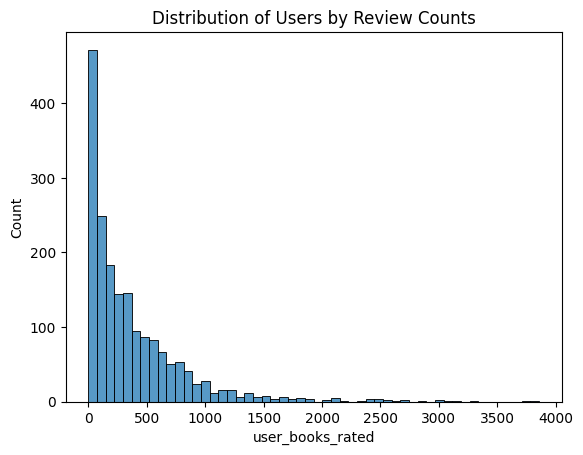

In [ ]:
sns.histplot(data=users['user_books_rated'], bins='fd')
plt.title('Distribution of Users by Review Counts')
plt.show()

It looks like a few users have rated a lot of books, and that is dragging up the average a lot. To get a better idea of what the typical user behavior looks like, I am going to look at the median number of reviews per user.

In [ ]:
median_user_review_count = users['user_books_rated'].median()
median_user_read_count = users['user_books_read'].median()

print(f"The median number of books reviewed by a user is: {median_user_review_count}")
print(f"The median number of books read by a user is: {median_user_read_count}")


The median number of books reviewed by a user is: 229.0
The median number of books read by a user is: 260.0


As expected, the median is a lot lower! Despite the average number of reviews per user being 376, fifty percent of users have rated fewer than 229 books. In a similar vein, the average number of books read is 411, but half of all users have read fewer than 260.

### Question 4: How best can we ID books?

I want find out how users interact with a typical book, but it will be a little bit more complicated because first I need to figure out how best to ID each book. While I could default to the 'book_id' generated by Goodreads, it can be far too specific for a recommendation algorithm. In Goodreads, a 'book id' is tied to an edition or format (e.g. Kindle, Audiobook, Paperback etc.) of each book. For example, in the output below we can see there are 91 different Goodreads book IDs associated with *Jane Eyre*.

In [ ]:
# Examining titles with multiple book Ids
most_common_titles = reads['title'].value_counts().reset_index()
most_common_titles.columns = ['title', 'occurances']

# Grouping book_ids to titles
title_ids = reads.groupby('title')['book_id'].unique().reset_index()
title_ids.columns = ['title', 'book_ids']
title_ids['num_unique'] = title_ids['book_ids'].apply(len)

titles = most_common_titles.merge(title_ids, on = 'title', how = 'inner', validate = "1:1")
titles.sort_values('num_unique', ascending=False,inplace=True)
titles.head(10)

,title,occurances,book_ids,num_unique
22,Jane Eyre,296,"[41223532, 22009309, 11016, 31568454, 10210, 1...",79
60,Frankenstein,229,"[18490, 20793663, 603259, 41571339, 7991688, 1...",63
100,Dracula,193,"[17245, 9786023, 588495, 100101805, 33532, 112...",55
655,Selected Poems,82,"[295149, 386270, 112200, 1058137, 65349, 33015...",54
128,Emma,179,"[7181805, 6969, 15861555, 51125383, 57941142, ...",53
12,Pride and Prejudice,324,"[110844, 1885, 15994711, 15769088, 1886, 11082...",53
65,Wuthering Heights,223,"[6147457, 348914, 6185, 36589634, 3819780, 484...",51
127,Anna Karenina,179,"[15841795, 5685, 15823480, 153, 58560955, 1734...",50
104,A Christmas Carol,192,"[37837745, 5326, 5981667, 5327, 4836076, 88290...",48
50,Little Women,237,"[15796908, 20893528, 45457693, 48814947, 59747...",47


For a book recommendation system, the book format is not of particular importance and so I want to find a way of identifying books that lumps all formats and editions under one ID. One thought would be to just use book title, but then I might run into the opposite issue: rather than having an identifier that is too specific, it could conflate two completely different books that share the same name. For example, in the output above, *Selected Poems* is associated with multiple book IDs, but this is likely because many poets have 'Selected Poems' as a title of a book.

In the code below, we can see the book titles that have been used by the most authors. As we might expect, these are very generic book names that are likely to be used by many authors.

Note: For anyone who is curious, Und = 'Untitled'

In [ ]:
# Examining books associated with multiple authors
book_to_author = reads.groupby('title')['author'].unique().reset_index()
book_to_author.columns = ['title', 'authors']
book_to_author['num_unique'] = book_to_author['authors'].apply(len)

# Looking at titles that have the highest number of different authors associated with them
book_to_author.sort_values('num_unique', ascending=False, inplace=True)
book_to_author.head(10)

,title,authors,num_unique
157676,Selected Poems,"[Plath, Sylvia, Eliot, T.S., Dickinson, Emily,...",42
30515,Broken,"[Slaughter, Karin, Haken, Nicola, Clay, Daniel...",20
84196,Hunted,"[Melki-Wegner, Skye, Todd, G.X., Spooner, Meag...",20
38712,Collected Stories,"[McCullers, Carson, Doctorow, E.L., Kipling, R...",20
149939,Redemption,"[Baldacci, David, Friend, J.E., Kingsbury, Kar...",19
224829,Twisted,"[McIntire, Emily, Shepard, Sara, Brody, Marjor...",18
81507,Home,"[Robinson, Marilynne, Berriman, Amanda, Harlan...",18
68185,Forget Me Not,"[Tyler, Q.B., Soto, Julie, Lewis, Luana, Allan...",18
210978,The Stranger,"[Camus, Albert, Hall, Joan, Coben, Harlan, Fer...",18
149525,Reckless,"[Silver, Elsie, Brubaker, Ed, Montgomery, Sele...",18


 Since authors are generally unlikely to give two of their books the same name, and it is very unlikely that two people with the same name would write a book with the same title, we can safely rely on this as a way identify specific books. The only potential drawback is this will not lump translations since the title will likely be in a different language, but it is still an improvement over the Goodreads generated ID. For this reason, I created a new ID, 'book_tag', which uses the author name and title to uniquely identify each book. (Scroll above to the Adding New Features section to see how that is done).

### Question 5: Which books are most popular?

As we saw above, the average book in this data set has been read 2.7 times by these users, with an average of 2.47 ratings. Below we can see which books have been read the most, as well as the number of times they have been read.

In [ ]:
books.sort_values('book_popularity_read', ascending=False).head(20)[['title', 'book_popularity_read']]

,title,book_popularity_read
528649,The Great Gatsby,376
529526,The Seven Husbands of Evelyn Hugo,366
529493,Daisy Jones & The Six,366
530262,The Guest List,364
1105235,"Tomorrow, and Tomorrow, and Tomorrow",359
531373,Harry Potter and the Chamber of Secrets,355
530206,The Midnight Library,349
1108005,Where the Crawdads Sing,348
531372,Harry Potter and the Prisoner of Azkaban,342
539159,The Hunger Games,342


This list of books above makes a lot of sense; it includes some of the most popular books at the time I scraped the data, as well as some classics like *The Great Gatsby*, *1984* and *Harry Potter*.

Given these numbers, I suspect that a few books are dragging up the average number of times each book is read or rated. Let's take a look at the distribution of ratings and reads for books.

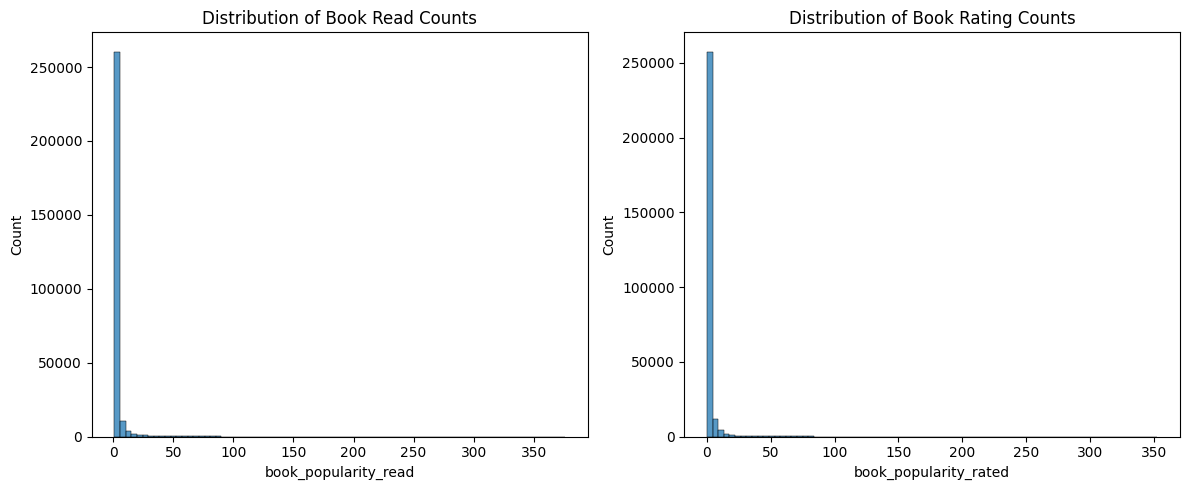

In [ ]:
# Create a Figure and two Axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

sns.histplot(data=books, bins=80, x='book_popularity_read', ax=axes[0])
axes[0].set_title('Distribution of Book Read Counts')

sns.histplot(data=books, bins=80, x='book_popularity_rated', ax=axes[1])
axes[1].set_title('Distribution of Book Rating Counts')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

It looks like an overwhelming majority of books have been rated or read only once, but it is very difficult to see from the figures alone. Let's take a closer look.

In [ ]:
one_review = len(books[books['book_popularity_rated'] <= 1])
one_read = len(books[books['book_popularity_read'] <= 1])

print(f"{round(one_review /n_books *100, 2)}% of books have received less than one review.")
print(f"{round(one_read /n_books* 100, 2)}% of books have been read at most once.")


71.58% of books have received less than one review.
69.16% of books have been read at most once.


### Question 6: How are readers rating books?

In the following section, we will dive into how users tend to rate books and how we can most accurately predict a book's average rating, given the reviews we have.

First, let's look at the distribution of user ratings

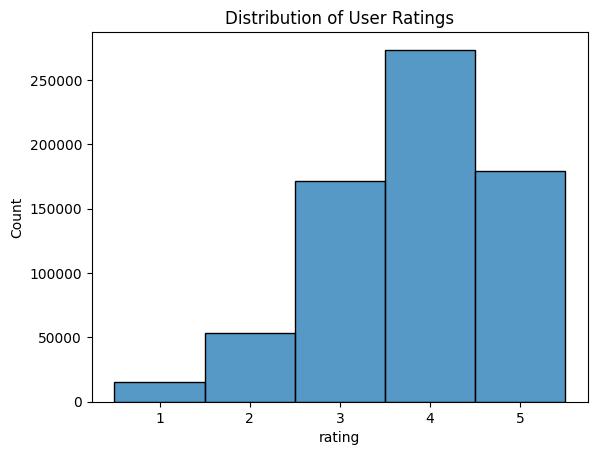

In [ ]:
sns.histplot(ratings['rating'],discrete=True)
plt.title('Distribution of User Ratings')
plt.show()

Reviewers tend to lean positive in their ratings, with the most common book rating being a 4, followed far behind by 5 and 3, which are nearly tied for second place. Let's take a look at the mean and median reviews.

In [ ]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")
print(f"Median global rating: {round(ratings['rating'].median(),0)}.")

Mean global rating: 3.79.
Median global rating: 4.0.


In [ ]:
mean_user_average_rating = ratings.drop_duplicates(['user_id'])['average_user_rating'].mean()
median_user_average_rating = ratings.drop_duplicates(['user_id'])['average_user_rating'].median()

print(f"Mean rating per user: {round(mean_user_average_rating,2)}.")
print(f"Median rating per user: {round(median_user_average_rating,2)}.")

Mean rating per user: 3.84.
Median rating per user: 3.84.



As we can see above, we get a slightly different mean if we first group by user. This is likely because a) users differ widely in the number of books they have read and b) users tend to rate books differently.

Some users may be more likely to give higher ratings than others users. The following graph displays the distribution of average ratings by user.

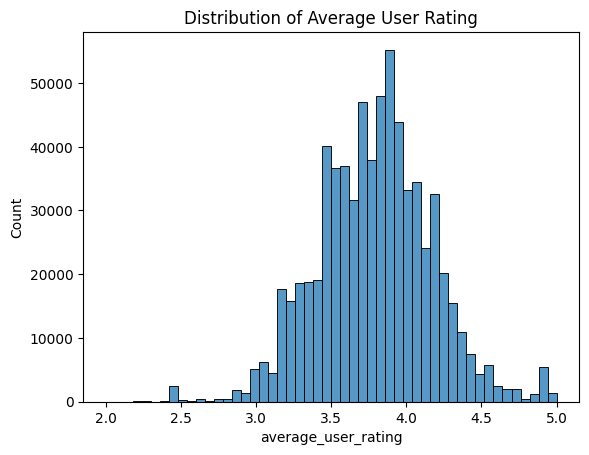

In [ ]:
sns.histplot(ratings['average_user_rating'], bins=50)
plt.title('Distribution of Average User Rating')
plt.show()

From the graph above, we can see that user's tend to rate books very differently. What may be a very good rating to one user, could be a very low rating for another user. One way to can account for this is normalizing ratings by user, which will be done later in preprocessing.

### Question 7: What are the lowest and highest rated books? What is the average book rating?

In [ ]:
mean_ratings = ratings.groupby('book_tag')[['rating']].mean().reset_index().sort_values('rating', ascending =False)
lowest_rated = mean_ratings['rating'].idxmin()
highest_rated = mean_ratings['rating'].idxmax()

print(f'Lowest rated book: {mean_ratings.iloc[lowest_rated, 0]}')
print(f'Highest rated book: {mean_ratings.iloc[highest_rated, 0]}')

Lowest rated book: Prague Winter: A Personal Story of Remembrance and War, 1937-1948; Albright, Madeleine K.
Highest rated book: !خرگوش گوش داد; Doerrfeld, Cori


Most of the books in this dataset have very few ratings. Therefore, calculating an average rating provides little value because the books with the highest and lowest reviews are likely to be books with one very high and low review, respectively. Thus, we are likely to get very strange answers for highest rated books if we rely solely on the traditional mean formula.

One potential solution to get a more accurate average for books with few ratings is the Bayesian average. A Bayesian average will rely on preexisting knowledge to form an estimate for the mean, and then update that estimate based on the data available. Below, we can use the average mean for each book as starting point and adjust based on user reviews of the book. The Bayesian average also involves a constant C, which determines how heavily the pior mean estimate will factor into the result. A larger C value means the prior mean will weigh more heavily. For the purposes of this calculation, we will use the average number of ratings a book has as our C value.

Before we do that, however, let's look at the mean rating for books that recieved the most reviews.

In [ ]:
book_stats = ratings.groupby('book_tag')['rating'].agg(['count', 'mean']).reset_index().sort_values('count', ascending=False)
book_stats.head()

,book_tag,count,mean
188176,"The Great Gatsby; Fitzgerald, F. Scott",353,3.971671
42921,"Daisy Jones & The Six; Reid, Taylor Jenkins",348,4.109195
206854,"The Seven Husbands of Evelyn Hugo; Reid, Taylo...",348,4.215517
188548,"The Guest List; Foley, Lucy",342,3.561404
220409,"Tomorrow, and Tomorrow, and Tomorrow; Zevin, G...",332,4.207831


As expected, the most popular books have relatively high reviews, but we are not seeing any 5-star or 1-stars. Instead, they are all relatively close to the average book score.

Now let's compute the Bayesian average.

In [ ]:
C = book_stats['count'].mean() # average number of reviews per book
m = book_stats['mean'].mean() # average rating per book

print(f"Average number of ratings for a given book, given that book has receieved at least one rating: {C:.2f}")
print(f"Average rating for a given book: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given book, given that book has receieved at least one rating: 2.67
Average rating for a given book: 3.73


In [ ]:
bayesian_avg_ratings = ratings.groupby('book_tag')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['book_tag', 'bayesian_avg']
book_stats = book_stats.merge(bayesian_avg_ratings, on='book_tag')

Now, when we look at the most popular books, the bayesian average will be very close to the mean rating.

In [ ]:
book_stats.sort_values('count', ascending=False).head()

,book_tag,count,mean,bayesian_avg
0,"The Great Gatsby; Fitzgerald, F. Scott",353,3.971671,3.970
1,"Daisy Jones & The Six; Reid, Taylor Jenkins",348,4.109195,4.106
2,"The Seven Husbands of Evelyn Hugo; Reid, Taylo...",348,4.215517,4.212
3,"The Guest List; Foley, Lucy",342,3.561404,3.563
4,"Tomorrow, and Tomorrow, and Tomorrow; Zevin, G...",332,4.207831,4.204


Where we see the biggest difference between the bayesian average and the mean rating is with the books with fewer ratings. In these cases, the prior rating plays a much bigger role.

In [ ]:
book_stats.sort_values('count', ascending=True).head()

,book_tag,count,mean,bayesian_avg
129915,"i$ubscribe: Gen Verismo Genesis; Flower, P.B. ...",1,3.0,3.532
173212,"Eunoia; Bök, Christian",1,4.0,3.804
173213,"Kilted Yoga: Yoga Laid Bare; Wilson, Finlay",1,5.0,4.077
173214,"Eumeswil; Jünger, Ernst",1,4.0,3.804
173215,Killing the Rising Sun: How America Vanquished...,1,3.0,3.532


## Data Preprocessing

Now that we have a fairly good idea what the data looks like, it's time to preprocess the data for modeling. In order to prep the data for the KNN model, we need to:

- normalize ratings
- filter outliers
- reshape data
- evaluate sparsity (and take appropriate measures)

#### Part A: Normalizing Ratings by User

Earlier we saw that users have vastly different average scores. One way we can account for this is by subtracting every users average rating from their book rating. This gives us a better idea how the user felt about the book by showing how it compared to their average score.

In [8]:
ratings['rating_norm'] = ((ratings['rating'] - ratings['average_user_rating']) /ratings['user_rating_variability']).fillna(0)

/var/folders/8j/jqvkfjr12ns3lzbxz2m8scx00000gp/T/ipykernel_36382/1278963452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['rating_norm'] = ((ratings['rating'] - ratings['average_user_rating']) /ratings['user_rating_variability']).fillna(0)


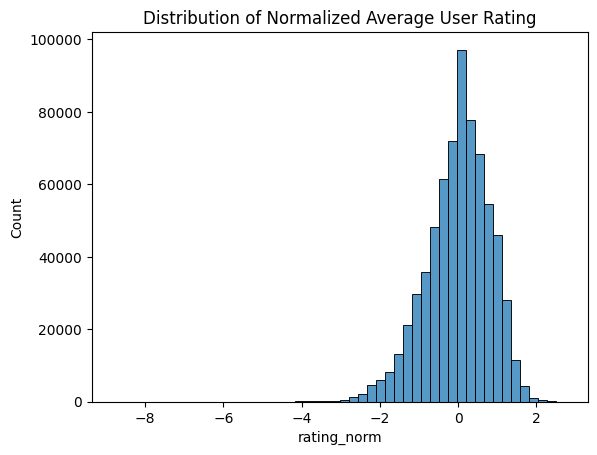

In [9]:
sns.histplot(ratings['rating_norm'], bins=50)
plt.title('Distribution of Normalized Average User Rating')
plt.show()

### Part B: Filtering Outliers

It may be beneficial to filter out users that have reviewed very few books (<5), as these users will not provide much information. Similarly, I am going to experiment with removing books with only one review, since I do not want the model to making connections solely off one data point. 

I am also going to remove ratings from users with very low rating variability. One of my favorite authors gives all the books she reads 5 stars which is incredibly sweet and kind, but very unhelpful for our purposes.

In [10]:
# Removing books with only one rating
ratings_filtered = ratings[ratings.book_popularity_rated > 1]

# Selecting only users that have read more than 5 books
ratings_filtered = ratings_filtered[ratings_filtered['user_books_rated'] > 5]

# Removing users that give every book the same rating
ratings_filtered = ratings_filtered[ratings_filtered['user_rating_variability'] > .001]

percent_remaining = round(len(ratings_filtered) / len(ratings) * 100, 2)

print(f"After filtering, {percent_remaining}% of ratings are remaining.")

After filtering, 74.02% of ratings are remaining.


### Part C: Reshaping Data

The function below generates a sparse matrix with rows representing each user and columns representing each book. Most indices of the matrix will be empty since most books have been read only once or twice, but wherever a user has read a book, the rating will appear in the matrix.

In [11]:
def generate_sparse_matrix(df, user_id, book_id, rating):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Arguments:
        df: pandas dataframe
        user_id: column name of user id
        book_id: column name of book id
        rating: column name of rating
    
    Returns:
        R: sparse ratings matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        book_mapper: dict that maps book id's to book indices
        book_inv_mapper: dict that maps book indices to book id's
    """
    M = df[user_id].nunique()
    N = df[book_id].nunique()

    user_mapper = dict(zip(np.unique(df[user_id]), list(range(M))))
    book_mapper = dict(zip(np.unique(df[book_id]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df[user_id])))
    book_inv_mapper = dict(zip(list(range(N)), np.unique(df[book_id])))
    
    user_index = [user_mapper[i] for i in df[user_id]]
    item_index = [book_mapper[i] for i in df[book_id]]

    R = csr_matrix((df[rating], (user_index,item_index)), shape=(M,N))
    
    return R, user_mapper, book_mapper, user_inv_mapper, book_inv_mapper


In the section below, 4 reshaped matrices are generated to test out for modeling purposes. The first two contain all of the data, with one using the normalized rating and the other using the unmodified rating. The second also has one with the regular rating and one with the normalized rating, however both are made with only the filtered data.

In [12]:
# Using all ratings to create X, using both rating and rating_norm for comparison
X, user_mapper, book_mapper, user_inv_mapper, book_inv_mapper = generate_sparse_matrix(ratings, user_id='user_id', book_id='book_tag', rating='rating')
Xn, user_mapper, book_mapper, user_inv_mapper, book_inv_mapper = generate_sparse_matrix(ratings, user_id='user_id', book_id='book_tag', rating='rating_norm')

# Using filtered ratings to create X, using both rating and rating_norm for comparison
Xf, user_mapper_f, book_mapper_f, user_inv_mapper_f, book_inv_mapper_f = generate_sparse_matrix(ratings_filtered, user_id='user_id', book_id='book_tag', rating='rating')
Xfn, user_mapper_f, book_mapper_f, user_inv_mapper_f, book_inv_mapper_f = generate_sparse_matrix(ratings_filtered, user_id='user_id', book_id='book_tag', rating='rating_norm')

In [13]:
print(X.shape)
print(Xn.shape)
print(Xf.shape)
print(Xfn.shape)

(1828, 259831)
(1828, 259831)
(1773, 79730)
(1773, 79730)


Since the first two matrices both use all the data, they have the same shape: 1,828 rows representing the 1,828 users and 259,831 rows to represent each book.

The last two matrices are smaller to represent the subset of users with more than 5 book reviews and books with more than one review. In total, we get 1,773 users reviewing 79,730 books.

### Part D: Evaluating matrix density

In order for KNN to run properly, it usually requires a certain level of density. A general rule of thumb is you want to have a density of at least 10%. Below, the density levels for all the matrices are calculated and reported.

In [14]:

def matrix_density(mat, name):
    '''
    Prints the matrix density of the matrix.

    Parameters:
        mat: a matrix
        name: a name for the matrix
    '''
    n_total = mat.shape[0]*mat.shape[1]
    n_ratings = mat.nnz
    density = n_ratings/n_total
    print(f"The {name} has a density of: {round(density * 100, 2)}%")

In [15]:
names = ['All Ratings Matrix', 'All Normalized Ratings Matrix', 'Filtered Ratings Matrix', 'Filtered Normalized Ratings Matrix']

matrices = dict(zip(names, [X, Xn, Xf, Xfn]))

for a, b in matrices.items():
    matrix_density(b, a)

The All Ratings Matrix has a density of: 0.15%
The All Normalized Ratings Matrix has a density of: 0.15%
The Filtered Ratings Matrix has a density of: 0.36%
The Filtered Normalized Ratings Matrix has a density of: 0.36%


The first two matrices have the same density of 0.15%, and the last two are over twice as dense with a 0.36% density. Both matrices are very far from the suggested 10% density.

The best approach to address this is likely to increase density by:
- filtering further (e.g. dropping books fewer than 5 ratings)
- using the user mean to fill empty ratings for books users have read
- predict user ratings via dimensionality reduction methods such as PCA or SVD

I spent a very long time trying to use SVD to accomplish this, and have not succeeded yet. The best RMSE score was around 3.1, which is pretty terrible. I have not given up just yet, but I have decided that, for the purposes of this project, we will focus solely on the first two approaches. 

Since we have already tried some filtering, let's start by filling missing ratings with user average reviews.

It is very convientient that we have the 'adjusted_rating' which fills all missing ratings with the user's average rating. Let's build a matrix with that.

In [16]:
# Removing books with only one rating
filled_and_filtered = reads[reads.book_popularity_read > 20]

# Selecting only users that have read more than 5 books
filled_and_filtered = filled_and_filtered[filled_and_filtered['user_books_read'] > 30]

# Removing users that give every book the same rating
filled_and_filtered = filled_and_filtered[filled_and_filtered['user_rating_variability'] > .001]

percent_remaining = round(len(filled_and_filtered) / len(reads) * 100, 2)

n_filtered_books = filled_and_filtered['book_tag'].nunique()
n_filtered_users = filled_and_filtered['user_id'].nunique()

print(f"After filtering, {percent_remaining}% of ratings are remaining.")
print(f"After filtering, there are {n_filtered_users} users remaining.")
print(f"After filtering, there are {n_filtered_books} books remaining.")

After filtering, 30.37% of ratings are remaining.
After filtering, there are 1586 users remaining.
After filtering, there are 4494 books remaining.


In [17]:

Xf_adjusted, user_mapper_f_adf, book_mapper_f_adj, user_inv_mapper_f_adj, book_inv_mapper_f_adj = generate_sparse_matrix(filled_and_filtered, user_id='user_id', book_id='book_tag', rating='adjusted_rating')
X_adjusted, user_mapper_adj, book_mapper_adj, user_inv_mapper_adj, book_inv_mapper_adj = generate_sparse_matrix(reads.dropna(subset='adjusted_rating'), user_id='user_id', book_id='book_tag', rating='adjusted_rating')

In [18]:
matrix_density(Xf_adjusted, 'Filtered Adjusted Matrix')
matrix_density(X_adjusted, 'Adjusted Matrix')

The Filtered Adjusted Matrix has a density of: 3.21%
The Adjusted Matrix has a density of: 0.15%


The density is still not great, but it is at least slightly better. Let's see how the KNN algorithm performs on these datasets.

## Item-item Recommendations with k-Nearest Neighbors

We are going to find the $k$ books that have the most similar user engagement vectors for book $i$.

In [19]:
from sklearn.neighbors import NearestNeighbors

def find_similar_books(book_id, X, book_mapper, book_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given book id.
    
    Args:
        book_id: id of the book of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar book ID's
    """
    X = X.T
    neighbour_ids = []
    
    book_ind = book_mapper[book_id]
    book_vec = X[book_ind]
    if isinstance(book_vec, (np.ndarray)):
        book_vec = book_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(book_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(book_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

## Compare Recommenders

In order to determine which recommender does the best job of recommending similar books, I am going to compare the recommendations each model outputs in two ways:

- First, I will be using genre data that I scraped from Goodreads. My theory is that a good recommendation system will tend to suggest books that have similar user-generated tags. The genre data can help create a difference score, indicating which recommendation systems tend to suggest books with different genres.

- Second, we will look at the recommendations for a few books I know quite well to see which model gives recommendations that make the most sense.

#### Recommendation Comparison function

In the chunk below, I am making a function that takes a book and generates recommendations with each function. I will use this later on to benchmark each model.

In [111]:
# Compare recommenders

def compare_recommenders(book, n):
    '''
    Returns a dataframe of n recommendations (rows) from each model (col)

    Parameters:
    book - the book to base recommendations on
    n - the number of recommendations to provide

    '''

    recs = []

    recs.append({'all_ratings': find_similar_books(book, X, book_mapper, book_inv_mapper, k=n)})
    recs.append({'all_ratings_normalized': find_similar_books(book, Xn, book_mapper, book_inv_mapper, k=n)})

    recs.append({'filtered_ratings': find_similar_books(book, Xf, book_mapper_f, book_inv_mapper_f, k=n)})
    recs.append({'filtered_ratings_normalized': find_similar_books(book, Xfn, book_mapper_f, book_inv_mapper_f, k=n)})

    recs.append({'ratings_filled': find_similar_books(book, X_adjusted, book_mapper_adj, book_inv_mapper_adj, k=n)})
    recs.append({'filtered_ratings_filled': find_similar_books(book, Xf_adjusted, book_mapper_f_adj, book_inv_mapper_f_adj, k=n)})

    recs_df = pd.DataFrame()

    for model in recs:
        recs_df[list(model.keys())[0]] = list(model.values())[0]

    recs_df.columns = ['Unfiltered Ratings', 'Unfiltered Normalized Ratings', 'Filtered Ratings', 'Filtered Normalized Ratings', 'Filled Ratings', 'Filtered & Filled Ratings']

    return recs_df

#### Loading in Genre Data

As mentioned above, I am going to use book genre data to assess which recommender does the best job suggesting books. The top 6 genre tags for roughly 8.5k books were scraped from Goodreads.

Genres are user-generated tags given to each book, allowing books to be classified and added to lists. For example, *Pride and Prejudice* is tagged as: fiction, "historical fiction", "historical", "literature", "audiobook", and "novels". My favorite book *My Brilliant Friend* is tagged as "fiction", "historical fiction", "italy", "literary fiction", "italian literature", and "contemporary". Some books have hundreds of tags, but only the top 6 for each book were collected.

In a previous project, the 25 most common genres were calculated and, for each of these genres, a column was added to the genre data indiciating if the book fell into that genre. For example, the most common genre is "Fiction" and for each book there is a column titled "is_fiction" that tracks whether the book is fiction or not.

Because only 6 genres for each book were tracked and the genres are user-generated, there are likely some missing genres for many of the books. In some cases this cannot be fixed, but further processing is done to ensure that each book's genre data is as accurate as possible. For example, if a book is tagged as 'mystery thriller', the code below also tags it as a 'mystery' and a 'thriller' independently.

In [609]:
# pulling in genre data
genres = pd.read_csv('data/genre_data.csv', index_col=False).drop_duplicates('link')

# Generating book ID from goodreads link
genres['book_id'] = genres['link'].str.replace('https://www.goodreads.com', '')
genres['book_id'] = genres['book_id'].str.replace('/book/show', '')
genres['book_id'] = genres['book_id'].apply(lambda x: re.sub(r'[^0-9.]', '', x))
genres['book_id'] = genres['book_id'].str.replace('.', '')

# Adding book tags to genre data
genres = genres.merge(reads[['book_tag', 'book_id', 'book_popularity_read']].drop_duplicates(['book_tag', 'book_id']),
 on = 'book_id', how = 'left', validate='1:m').drop_duplicates('book_tag')

# if all_genres contains literature: is literature, is novel
genres.loc[(genres['all_genres'].str.contains('literature', case=False, na=False)), ['is_literature', 'is_novel']] = True

# if all_genres contains literary: is literature, is literary
genres.loc[(genres['all_genres'].str.contains('literary', case=False, na=False)), ['is_literature', 'is_literary']] = True

# if all_genres contains romantic: is literature, is romance
genres.loc[(genres['all_genres'].str.contains('romantic', case=False, na=False)), ['is_romance']] = True

# if all_genres contains queer: is_lgbt
genres.loc[(genres['all_genres'].str.contains('queer', case=False, na=False)), ['is_lgbt']] = True

# if literary fiction then literary: is literary, is fiction
genres.loc[(genres['is_literary fiction']), ['is_literary', 'is_fiction']] = True

# if contemporary romance: is romance, is contemporary
genres.loc[(genres['is_contemporary romance']), ['is_contemporary', 'is_romance', 'is_fiction']] = True

# if is mystery thriller: is mystery, is thriller
genres.loc[(genres['is_mystery thriller']), ['is_mystery', 'is_thriller', 'is_fiction']] = True

# if historical fiction then: is historical, is fiction
genres.loc[(genres['is_historical fiction']), ['is_historical', 'is_fiction']] = True

# if literature -> fiction
genres.loc[(genres['is_literature']), ['is_literary', 'is_fiction', 'is_classic']] = True

# if mystery -> fiction
genres.loc[(genres['is_mystery']), ['is_suspense', 'is_fiction']] = True

# if novels -> fiction
genres.loc[(genres['is_novels']), ['is_fiction']] = True

# if science fiction -> fiction
genres.loc[(genres['is_science fiction']), ['is_fiction']] = True

# if is horror -> thriller
genres.loc[(genres['is_horror']), ['is_thriller']] = True

# if crime -> mystery (probably)
genres.loc[(genres['is_crime']), ['is_thriller', 'is_mystery']] = True

# subsetting relevent genres (leaving out audiobook because that edition specific)
genre_classification_data = genres[['book_tag','is_fiction', 'is_contemporary', 'is_fantasy',
       'is_mystery', 'is_historical fiction', 'is_romance', 'is_thriller',
       'is_literary fiction', 'is_young adult', 'is_classics',
       'is_mystery thriller', 'is_adult', 'is_historical', 'is_horror',
       'is_science fiction', 'is_nonfiction', 'is_literature', 'is_novels',
       'is_lgbt', 'is_suspense', 'is_crime', 'is_memoir',
       'is_contemporary romance']]


Now I am going to make a function that computes a difference between the genres of a given book and a list of recommended books.

In [610]:
def genre_match_score(book, rec_list):
    '''
    Compares genre info of book to recommendations to the associated book
    
    Returns a tuple with the number of books for which genre info exists,
    as well as the mean score of agreement (i.e. the mean of differences in genre
    between the book and the recommended books.)
    '''

    # getting book info
    book_vec = book_genre_data.loc[(book_genre_data['book_tag'] == book), :].drop(columns=['book_tag'])
    n_matches = 0
    diff_sum = 0

    # checking if the book has genre info
    if len(book_vec) > 0:
        # going through each recommended book
        for book in rec_list:
            # getting genre info for book
            comp_vec = book_genre_data.loc[book_genre_data['book_tag'] == book, :].drop(columns=['book_tag'])
            # if book has genre info
            if len(comp_vec > 0):
                n_matches += 1
                diff = (book_vec.squeeze() != comp_vec.squeeze()).sum()
                diff_sum += diff
            else:
                pass
        if n_matches > 0:
            return tuple([n_matches, round(diff_sum / n_matches, 2)])
        else:
            return tuple([0,-2])

    else:
        return tuple([0, -1])

Below is an example of the score difference between two different novels

In [611]:
genre_match_score('My Brilliant Friend; Ferrante, Elena', ['Persuasion; Austen, Jane', 'The Bell Jar; Plath, Sylvia'])

(2, np.float64(4.0))

These novels are similar; they are literary fiction and historical accounts of female experiences. They have a similarity score of 4, which is relatively low. Now let's take a look at a few books that are very different from *My Brilliant Friend*: two fantasy books: *Babel* and *A Court of Thorns and Roses*.

In [612]:
genre_match_score('My Brilliant Friend; Ferrante, Elena', ['Babel; Kuang, R.F.', 'A Court of Thorns and Roses; Maas, Sarah J.'])

(2, np.float64(8.0))

As expected, the two books that are less similar have a much higher score of 8--double that of the similar books. 

Of course, there is more to a book than its Goodreads tags which is why the primary way of assessing similarity is through user ratings, but this will serve as helpful corroboration. In the following section, we will assess model performance based on which model is more likely to suggest books with more genre differences. 

In [613]:
books_to_check = genres.sort_values('book_popularity_read', ascending=False).head(1500)['book_tag']

In [621]:
models = ['Unfiltered Ratings', 'Unfiltered Normalized Ratings', 'Filtered Ratings', 'Filtered Normalized Ratings', 'Filled Ratings', 'Filtered & Filled Ratings']

score_df = pd.DataFrame(columns = ['Book', 'Unfiltered Ratings', 'Unfiltered Normalized Ratings', 'Filtered Ratings', 'Filtered Normalized Ratings', 'Filled Ratings', 'Filtered & Filled Ratings'])

n_match_df =pd.DataFrame(columns = ['Book', 'Unfiltered Ratings', 'Unfiltered Normalized Ratings', 'Filtered Ratings', 'Filtered Normalized Ratings', 'Filled Ratings', 'Filtered & Filled Ratings'])

# iterating through books 
for book in books_to_check:
    # get df of recs from each model
    recs = compare_recommenders(book, 20)
    scores_for_book = [book]
    matches_for_book = [book]
    # get genre_match_score for each model
    for model in models:
        n_matches, mean_diff = genre_match_score(book, recs[model])
        scores_for_book.append(mean_diff)
        matches_for_book.append(n_matches)
    score_df.loc[len(score_df)] = scores_for_book
    n_match_df.loc[len(score_df)] = matches_for_book


In [623]:
scores_complete = score_df.drop('Book', axis=1)

scores_complete = scores_complete[(scores_complete > -1).all(axis=1)]

print(f"{len(scores_complete)} books have matches for all models")

average_model_scores = scores_complete.agg('mean')
average_model_scores

570 books have matches for all models


Unfiltered Ratings               4.336018
Unfiltered Normalized Ratings    5.009947
Filtered Ratings                 4.350789
Filtered Normalized Ratings      5.179719
Filled Ratings                   4.339579
Filtered & Filled Ratings        4.512088
dtype: float64

Based on the scores above, the model that tended to have the fewest genre deviations is Filled Ratings. Now let's take a look at the recommendations for a few books.

In [584]:
compare_recommenders('Pride and Prejudice; Austen, Jane', 11)

,Unfiltered Ratings,Unfiltered Normalized Ratings,Filtered Ratings,Filtered Normalized Ratings,Filled Ratings,Filtered & Filled Ratings
0,"Sense and Sensibility; Austen, Jane","Sense and Sensibility; Austen, Jane","Sense and Sensibility; Austen, Jane","Sense and Sensibility; Austen, Jane","Sense and Sensibility; Austen, Jane","Sense and Sensibility; Austen, Jane"
1,"Jane Eyre; Brontë, Charlotte","To Kill a Mockingbird; Lee, Harper","Jane Eyre; Brontë, Charlotte","To Kill a Mockingbird; Lee, Harper","Jane Eyre; Brontë, Charlotte","Jane Eyre; Brontë, Charlotte"
2,"Wuthering Heights; Brontë, Emily","Emma; Austen, Jane","Wuthering Heights; Brontë, Emily","Emma; Austen, Jane","Wuthering Heights; Brontë, Emily","Wuthering Heights; Brontë, Emily"
3,"To Kill a Mockingbird; Lee, Harper","Persuasion; Austen, Jane","To Kill a Mockingbird; Lee, Harper","Persuasion; Austen, Jane","To Kill a Mockingbird; Lee, Harper","To Kill a Mockingbird; Lee, Harper"
4,"Emma; Austen, Jane","Jane Eyre; Brontë, Charlotte","Emma; Austen, Jane","Jane Eyre; Brontë, Charlotte","Emma; Austen, Jane","Emma; Austen, Jane"
5,"The Great Gatsby; Fitzgerald, F. Scott","Anne of Green Gables; Montgomery, L.M.","The Great Gatsby; Fitzgerald, F. Scott","Anne of Green Gables; Montgomery, L.M.","The Great Gatsby; Fitzgerald, F. Scott","The Great Gatsby; Fitzgerald, F. Scott"
6,"Persuasion; Austen, Jane","One Piece, Volume 15: Straight Ahead!; Oda, Ei...","Persuasion; Austen, Jane","One Piece, Volume 15: Straight Ahead!; Oda, Ei...","Persuasion; Austen, Jane","Persuasion; Austen, Jane"
7,"Little Women; Alcott, Louisa May","The Importance of Being Earnest; Wilde, Oscar","Little Women; Alcott, Louisa May","The Importance of Being Earnest; Wilde, Oscar","Little Women; Alcott, Louisa May","Little Women; Alcott, Louisa May"
8,"The Hunger Games; Collins, Suzanne","East of Eden; Steinbeck, John","The Hunger Games; Collins, Suzanne","East of Eden; Steinbeck, John","The Hunger Games; Collins, Suzanne","The Hunger Games; Collins, Suzanne"
9,"The Book Thief; Zusak, Markus",Harry Potter and the Prisoner of Azkaban; Rowl...,"The Book Thief; Zusak, Markus",Harry Potter and the Prisoner of Azkaban; Rowl...,"Animal Farm; Orwell, George","Animal Farm; Orwell, George"


In [521]:
compare_recommenders('The Guest List; Foley, Lucy', 11)

,Unfiltered Ratings,Unfiltered Normalized Ratings,Filtered Ratings,Filtered Normalized Ratings,Filled Ratings,Filtered & Filled Ratings
0,"The Last Thing He Told Me; Dave, Laura","Wolfhunter River; Caine, Rachel","The Last Thing He Told Me; Dave, Laura","Wolfhunter River; Caine, Rachel","The Paris Apartment; Foley, Lucy","The Paris Apartment; Foley, Lucy"
1,"The Paris Apartment; Foley, Lucy","The Blood Spilt; Larsson, Åsa","The Paris Apartment; Foley, Lucy","The Blood Spilt; Larsson, Åsa","The Last Thing He Told Me; Dave, Laura","The Last Thing He Told Me; Dave, Laura"
2,"The Midnight Library; Haig, Matt","The Stranger; Conway, Simon","The Midnight Library; Haig, Matt","Victim Without a Face; Ahnhem, Stefan","Rock Paper Scissors; Feeney, Alice","Rock Paper Scissors; Feeney, Alice"
3,"The Silent Patient; Michaelides, Alex","Темные аллеи. Повести и рассказы; Bunin, Ivan","The Silent Patient; Michaelides, Alex","Мои мужчины; Tokareva, Viktoriya","The Silent Patient; Michaelides, Alex","The Silent Patient; Michaelides, Alex"
4,"Rock Paper Scissors; Feeney, Alice","Я исповедуюсь; Cabré, Jaume","Rock Paper Scissors; Feeney, Alice","Metro 2033; Glukhovsky, Dmitry","Malibu Rising; Reid, Taylor Jenkins","Malibu Rising; Reid, Taylor Jenkins"
5,"The Family Upstairs; Jewell, Lisa","An Ace and A Pair; Banner, Blake","The Family Upstairs; Jewell, Lisa","Crimson Rivers; Grangé, Jean-Christophe","The Family Upstairs; Jewell, Lisa","The Family Upstairs; Jewell, Lisa"
6,"The Maidens; Michaelides, Alex","The Sea Detective; Douglas-Home, Mark","The Maidens; Michaelides, Alex","Понаехавшая; Abgaryan, Narine","Home Before Dark; Sager, Riley","The Midnight Library; Haig, Matt"
7,"Malibu Rising; Reid, Taylor Jenkins","Одиночество в сети; Wiśniewski, Janusz Leon","Malibu Rising; Reid, Taylor Jenkins","Date Night; Hayes, Samantha","The Midnight Library; Haig, Matt","Home Before Dark; Sager, Riley"
8,"Home Before Dark; Sager, Riley","Дневник кота-убийцы. Все истории; Fine, Anne","Home Before Dark; Sager, Riley",The Nicomachean Ethics; Aristotle,"The Maidens; Michaelides, Alex","The Maidens; Michaelides, Alex"
9,"Book Lovers; Henry, Emily","Брошенная в бездну; Kemal, Orhan","Book Lovers; Henry, Emily",Under the Overpass: A Journey of Faith on the ...,"The Seven Husbands of Evelyn Hugo; Reid, Taylo...","The Seven Husbands of Evelyn Hugo; Reid, Taylo..."


In [522]:
compare_recommenders('My Brilliant Friend; Ferrante, Elena', 11)

,Unfiltered Ratings,Unfiltered Normalized Ratings,Filtered Ratings,Filtered Normalized Ratings,Filled Ratings,Filtered & Filled Ratings
0,"The Story of a New Name; Ferrante, Elena","The Story of a New Name; Ferrante, Elena","The Story of a New Name; Ferrante, Elena","The Story of a New Name; Ferrante, Elena","The Story of a New Name; Ferrante, Elena","The Story of a New Name; Ferrante, Elena"
1,"Those Who Leave and Those Who Stay; Ferrante, ...","Those Who Leave and Those Who Stay; Ferrante, ...","Those Who Leave and Those Who Stay; Ferrante, ...","Those Who Leave and Those Who Stay; Ferrante, ...","Those Who Leave and Those Who Stay; Ferrante, ...","Those Who Leave and Those Who Stay; Ferrante, ..."
2,"The Story of the Lost Child; Ferrante, Elena","The Story of the Lost Child; Ferrante, Elena","The Story of the Lost Child; Ferrante, Elena","The Story of the Lost Child; Ferrante, Elena","The Story of the Lost Child; Ferrante, Elena","The Story of the Lost Child; Ferrante, Elena"
3,"Lincoln in the Bardo; Saunders, George","The Kingdom on the Waves; Anderson, M.T.","Lincoln in the Bardo; Saunders, George","The Kingdom on the Waves; Anderson, M.T.","The Goldfinch; Tartt, Donna","The Goldfinch; Tartt, Donna"
4,"Pachinko; Lee, Min Jin","How to Cook a Wolf; Fisher, M.F.K.","Pachinko; Lee, Min Jin","How to Cook a Wolf; Fisher, M.F.K.","Americanah; Adichie, Chimamanda Ngozi","Americanah; Adichie, Chimamanda Ngozi"
5,"The Goldfinch; Tartt, Donna","Wild by Nature: From Siberia to Australia, Thr...","The Goldfinch; Tartt, Donna",A Life of One's Own: Nine Women Writers Begin ...,"Lincoln in the Bardo; Saunders, George","Lincoln in the Bardo; Saunders, George"
6,The Vegetarian; Han Kang,"Folk and Fairy Tales; Hallett, Martin",The Vegetarian; Han Kang,"The Jedera Adventure; Alexander, Lloyd","Pachinko; Lee, Min Jin","Girl, Woman, Other; Evaristo, Bernardine"
7,"The Underground Railroad; Whitehead, Colson",Assume Nothing: A Story of Intimate Violence; ...,"The Underground Railroad; Whitehead, Colson","Prologue to Murder; Elliott, Lauren","Girl, Woman, Other; Evaristo, Bernardine",The Vegetarian; Han Kang
8,"Girl, Woman, Other; Evaristo, Bernardine","Escaping the Dead; Lundy, W.J.","Girl, Woman, Other; Evaristo, Bernardine","Delicious Monsters; Sambury, Liselle",The Vegetarian; Han Kang,"Pachinko; Lee, Min Jin"
9,"The Lost Daughter; Ferrante, Elena","A Natural History of Hell; Ford, Jeffrey","The Lost Daughter; Ferrante, Elena",Sylvia Beach and the Lost Generation: A Histor...,"Commonwealth; Patchett, Ann","Commonwealth; Patchett, Ann"


In [523]:
compare_recommenders('The Goldfinch; Tartt, Donna', 11)

,Unfiltered Ratings,Unfiltered Normalized Ratings,Filtered Ratings,Filtered Normalized Ratings,Filled Ratings,Filtered & Filled Ratings
0,"The Secret History; Tartt, Donna",Addicted; Zane,"The Secret History; Tartt, Donna",Addicted; Zane,"The Secret History; Tartt, Donna","The Secret History; Tartt, Donna"
1,"Station Eleven; Mandel, Emily St. John","The Hours; Cunningham, Michael","Station Eleven; Mandel, Emily St. John","The Hours; Cunningham, Michael","Station Eleven; Mandel, Emily St. John","Station Eleven; Mandel, Emily St. John"
2,"All the Light We Cannot See; Doerr, Anthony",Being Nixon: The Fears and Hopes of an America...,"All the Light We Cannot See; Doerr, Anthony",Being Nixon: The Fears and Hopes of an America...,"All the Light We Cannot See; Doerr, Anthony","All the Light We Cannot See; Doerr, Anthony"
3,"The Great Gatsby; Fitzgerald, F. Scott","The Wind Done Gone; Randall, Alice","The Great Gatsby; Fitzgerald, F. Scott","The Wind Done Gone; Randall, Alice","The Handmaid’s Tale; Atwood, Margaret","The Handmaid’s Tale; Atwood, Margaret"
4,"The Handmaid’s Tale; Atwood, Margaret","Murder as a Fine Art; Morrell, David","The Handmaid’s Tale; Atwood, Margaret","Murder as a Fine Art; Morrell, David","Fates and Furies; Groff, Lauren","Fates and Furies; Groff, Lauren"
5,"Never Let Me Go; Ishiguro, Kazuo","Prince Lestat; Rice, Anne","Never Let Me Go; Ishiguro, Kazuo","Prince Lestat; Rice, Anne","The Great Gatsby; Fitzgerald, F. Scott","The Great Gatsby; Fitzgerald, F. Scott"
6,"Fates and Furies; Groff, Lauren",The Advantage: Why Organizational Health Trump...,"Fates and Furies; Groff, Lauren",Final Exits: The Illustrated Encyclopedia of H...,"My Brilliant Friend; Ferrante, Elena","My Brilliant Friend; Ferrante, Elena"
7,"Middlesex; Eugenides, Jeffrey","Wisconsin Death Trip; Lesy, Michael","Middlesex; Eugenides, Jeffrey",The 5 Levels of Leadership: Proven Steps to Ma...,"Never Let Me Go; Ishiguro, Kazuo","Never Let Me Go; Ishiguro, Kazuo"
8,"The Underground Railroad; Whitehead, Colson","In the Dark of the Night; Saul, John","The Underground Railroad; Whitehead, Colson","Whispers Beyond the Veil; Estevao, Jessica","Middlesex; Eugenides, Jeffrey","Middlesex; Eugenides, Jeffrey"
9,"The Dutch House; Patchett, Ann","Double Feature: A Novel; King, Owen","The Dutch House; Patchett, Ann","The Unquiet; Robb, J.D.","The Underground Railroad; Whitehead, Colson","The Underground Railroad; Whitehead, Colson"


Looking at actual recommendations for books I know very well, I can see that normalization and seems to provide little value and tends to return stranger results. Filling empty reviews with the average user review did not do much harm to the recommendations, but it did not appear to add much value. Filtering, on the other hand, did seem to provide a small benefit, and so the the filtered rating processing approach is what I will use to generate recommendations in the next section.

## Generate Recommendations Based on My Recent Reading Habits

Now it's time to use the recommender. Below I have compiled a list of some of recent favorites in hopes that I can get some similar books to read next.

In [20]:
recent_favorites = ['My Brilliant Friend; Ferrante, Elena',
'The Secret History; Tartt, Donna',
'Intermezzo; Rooney, Sally',
'The Idiot; Batuman, Elif',
'The God of the Woods; Moore, Liz',
'Sense and Sensibility; Austen, Jane',
'Interpreter of Maladies; Lahiri, Jhumpa',
'Persuasion; Austen, Jane',
'Bel Canto; Patchett, Ann'
]

def get_new_recs():
    #recent_favorites = recent_favorites#
    suggestions = list()
    for book_tag in recent_favorites:
        try:
            sugs = find_similar_books(book_tag, X_adjusted, book_mapper_adj, book_inv_mapper_adj, k=7)
            suggestions.append({"Recently Read": book_tag, **{f"Suggestion {i+1}": sugs[i] for i in range(len(sugs))}})
        except:
            print('There is no data on: ' + book_tag)
    return pd.DataFrame(suggestions)

reading_list = get_new_recs()


There is no data on: Intermezzo; Rooney, Sally


It makes sense that there is no information on *Intermezzo* since that book came out after most of this data was collected. It looks like I will need to scrape more libraries if I want to get recommendations for the most recent books.

 For now, let's see what I suggestions I have in the table below.

In [21]:
display(reading_list)

,Recently Read,Suggestion 1,Suggestion 2,Suggestion 3,Suggestion 4,Suggestion 5,Suggestion 6
0,"My Brilliant Friend; Ferrante, Elena","The Story of a New Name; Ferrante, Elena","Those Who Leave and Those Who Stay; Ferrante, ...","The Story of the Lost Child; Ferrante, Elena","The Goldfinch; Tartt, Donna","Americanah; Adichie, Chimamanda Ngozi","Lincoln in the Bardo; Saunders, George"
1,"The Secret History; Tartt, Donna","The Goldfinch; Tartt, Donna","A Little Life; Yanagihara, Hanya","Never Let Me Go; Ishiguro, Kazuo","The Great Gatsby; Fitzgerald, F. Scott","The Bell Jar; Plath, Sylvia","Normal People; Rooney, Sally"
2,"The Idiot; Batuman, Elif","Either/Or; Batuman, Elif","Milk Fed; Broder, Melissa","The Pisces; Broder, Melissa","The Argonauts; Nelson, Maggie",Trick Mirror: Reflections on Self-Delusion; To...,"Eileen; Moshfegh, Ottessa"
3,"The God of the Woods; Moore, Liz","Someone in the Attic; Mara, Andrea","Hunted; Mukherjee, Abir","The Unquiet Bones; White, Loreth Anne","Sadie Sprocket Builds a Rocket; Fliess, Sue","A Very Cornish Christmas; Good, Beth","Bird Milk & Mosquito Bones: A Memoir; Mattoo, ..."
4,"Sense and Sensibility; Austen, Jane","Persuasion; Austen, Jane","Pride and Prejudice; Austen, Jane","Emma; Austen, Jane","Northanger Abbey; Austen, Jane","Mansfield Park; Austen, Jane","Jane Eyre; Brontë, Charlotte"
5,"Interpreter of Maladies; Lahiri, Jhumpa","The Namesake; Lahiri, Jhumpa","The God of Small Things; Roy, Arundhati","Unaccustomed Earth; Lahiri, Jhumpa","Bel Canto; Patchett, Ann","The Brief Wondrous Life of Oscar Wao; Díaz, Junot","The Poisonwood Bible; Kingsolver, Barbara"
6,"Persuasion; Austen, Jane","Sense and Sensibility; Austen, Jane","Emma; Austen, Jane","Northanger Abbey; Austen, Jane","Pride and Prejudice; Austen, Jane","Mansfield Park; Austen, Jane","Jane Eyre; Brontë, Charlotte"
7,"Bel Canto; Patchett, Ann","State of Wonder; Patchett, Ann","The Dutch House; Patchett, Ann","Commonwealth; Patchett, Ann","The Magician's Assistant; Patchett, Ann","To Kill a Mockingbird; Lee, Harper","All the Light We Cannot See; Doerr, Anthony"


In [540]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=list(reading_list.columns), 
                fill_color="rgba(0, 123, 255, 0.8)", 
                align="center",
                font=dict(color="white", size=14, family="Roboto"),
                height=40
            ),
            cells=dict(
                values=[reading_list[col] for col in reading_list.columns],
                fill_color=[
                    ['rgba(50, 50, 50, 0.8)', 'rgba(35, 35, 35, 0.8)'] * (len(reading_list) // 2) 
                ],  
                align="center",
                font=dict(color="white", size=16, family="Roboto"),  
                height=30
            ),
        )
    ]
)

fig.update_layout(
    title="Recommendations Based on My Current Reading",
    title_x=0.5,  # Center the title
    title_font=dict(size=24, family="Roboto", color="white"),
    plot_bgcolor="black",  
)

fig.show()
